In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps
import tifffile as tf

In [2]:
data_src = r"D:\Data\both 800fps\brightfield\*tif"

In [3]:
oog = OG.BasicOpticalGating()#.default()
oog.sequence_manager.set_source(data_src)
oog.run()

Setting source to D:\Data\both 800fps\brightfield\*tif
Getting reference sequence
Reference period: 306.2209554777414; Reference indices: [111, 422]
Getting SADs
Getting phases


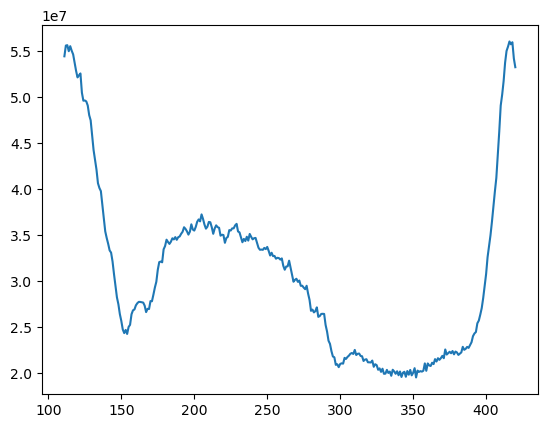

In [4]:
ref_seq = oog.sequence_manager.reference_sequence.astype(np.int64)
# Get sum of frame to frame differences for reference sequence
ref_diff = np.sum(np.abs(np.diff(ref_seq, axis=0)), axis=(1,2))
plt.plot(np.arange(oog.sequence_manager.reference_indices[0], len(ref_diff) + oog.sequence_manager.reference_indices[0]), ref_diff)
plt.show()

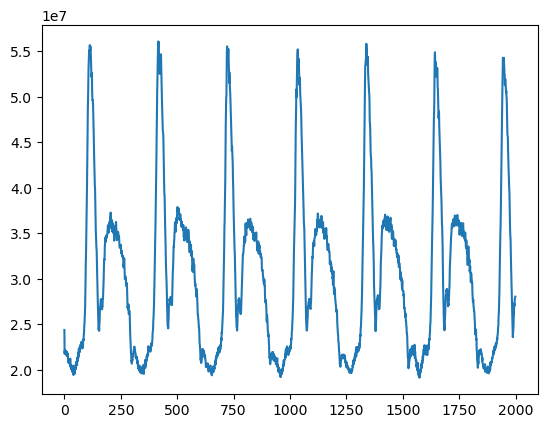

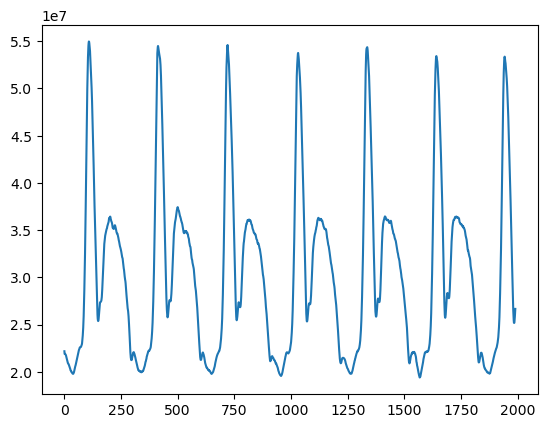

In [5]:
data = tf.imread(data_src).astype(np.int32)
# Get sum of frame to frame differences
diffs = np.sum(np.abs(data[1:] - data[:-1]), axis=(1,2))
plt.plot(diffs)
plt.show()

# Plot moving average of differences
window = 10
diffs_ma = np.convolve(diffs, np.ones(window)/window, mode='valid')
plt.plot(diffs_ma)
plt.show()

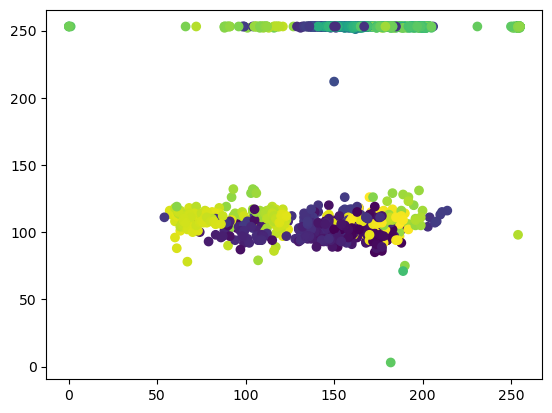

'plt.plot(np.sum(diff_imgs, axis=(1,2)))\nplt.show()\nplt.imshow(diff_imgs[200]**2)\nplt.show()'

In [6]:
from scipy.ndimage import median_filter

data_gaussian_filtered = []
for frame in data:
    data_gaussian_filtered.append(median_filter(frame, 8))

data_gaussian_filtered = np.asarray(data_gaussian_filtered)

diff_imgs = np.abs(data_gaussian_filtered[1:] - data_gaussian_filtered[:-1])

xmax = (np.argmax(np.sum(diff_imgs, axis = 1), axis = 1))
ymax = (np.argmax(np.sum(diff_imgs, axis = 2), axis = 1))
plt.scatter(xmax, ymax, c = oog.phases)
plt.show()

"""plt.plot(np.sum(diff_imgs, axis=(1,2)))
plt.show()
plt.imshow(diff_imgs[200]**2)
plt.show()"""

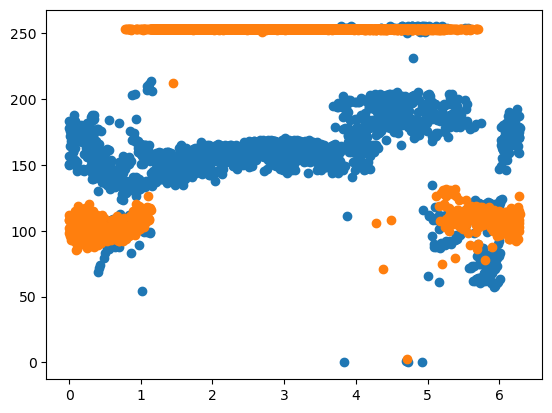

In [7]:
plt.scatter(oog.phases, xmax)
plt.scatter(oog.phases, ymax)

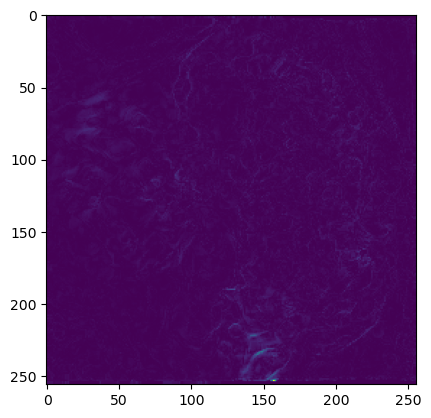

In [8]:
plt.imshow(diff_imgs[170])

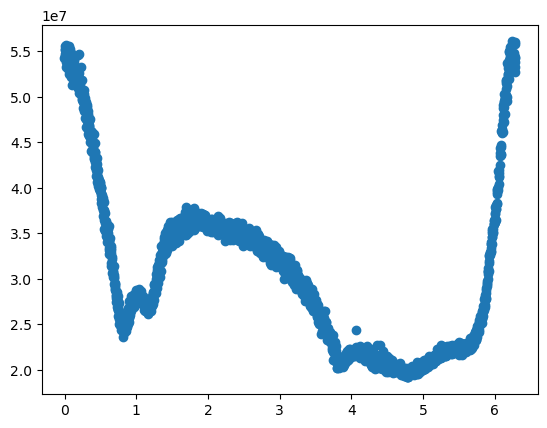

In [9]:
plt.scatter(oog.phases, diffs)
plt.show()

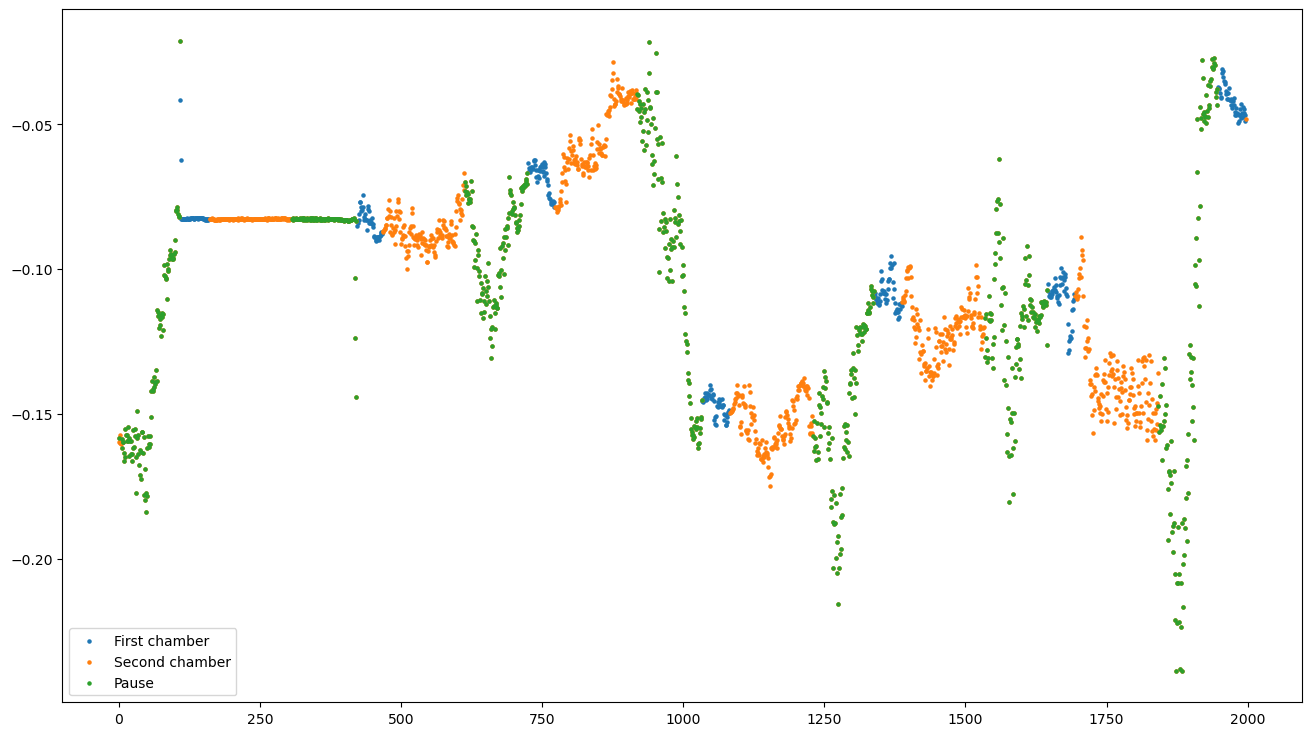

In [10]:
plt.figure(figsize = (16,9))
argsfirstchamber = ((np.where(oog.phases < 1)) or (np.where(oog.phases > 5.7)))
plt.scatter(np.arange(oog.delta_phases.shape[0])[argsfirstchamber], np.cumsum(oog.delta_phases - (2 * np.pi / oog.sequence_manager.reference_period))[argsfirstchamber], s = 5, label = 'First chamber')
argssecondchamber = ((np.where(oog.phases[0:-1] > 1)) or (np.where(oog.phases[0:-1] < 4)))
plt.scatter(np.arange(oog.delta_phases.shape[0])[argssecondchamber], np.cumsum(oog.delta_phases - (2 * np.pi / oog.sequence_manager.reference_period))[argssecondchamber], s = 5, label = 'Second chamber')
argspause = ((np.where(oog.phases[0:-1] > 4)) or (np.where(oog.phases[0:-1] < 5.7)))
plt.scatter(np.arange(oog.delta_phases.shape[0])[argspause], np.cumsum(oog.delta_phases - (2 * np.pi / oog.sequence_manager.reference_period))[argspause], s = 5, label = 'Pause')
plt.legend()
plt.show()

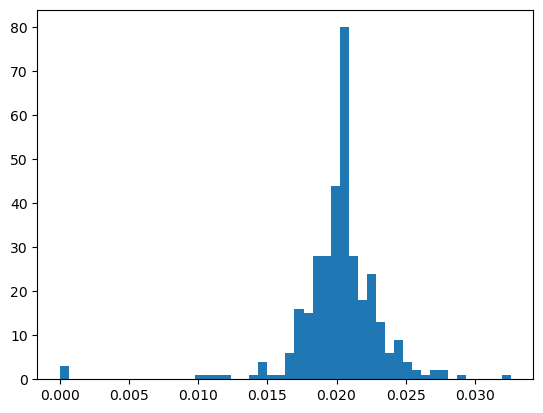

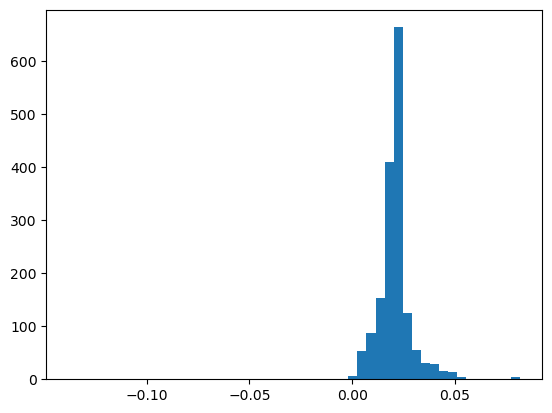

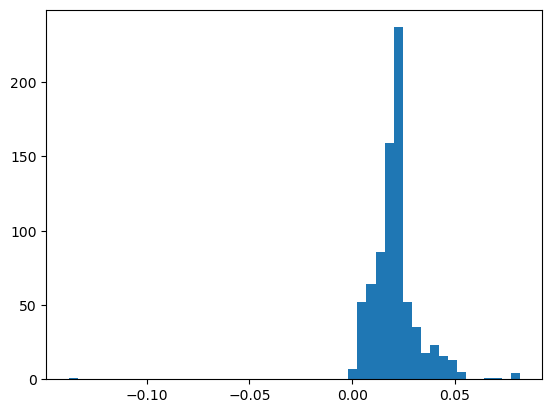

In [25]:
plt.hist(oog.delta_phases[argsfirstchamber], bins = 50)
plt.show()
plt.hist(oog.delta_phases[argssecondchamber], bins = 50)
plt.show()
plt.hist(oog.delta_phases[argspause], bins = 50)
plt.show()

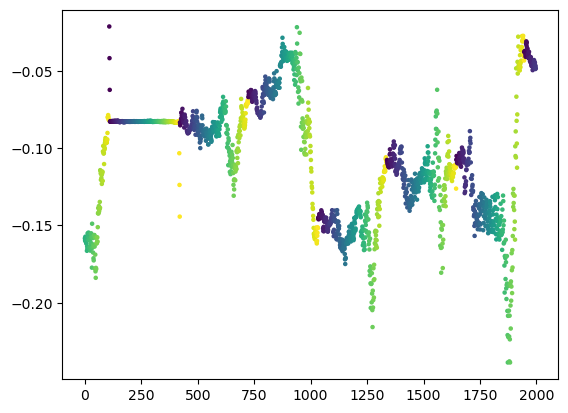

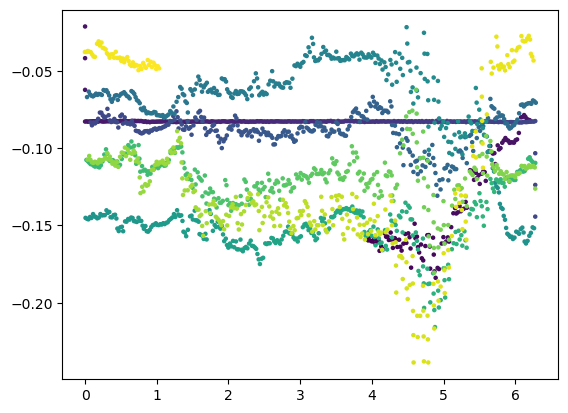

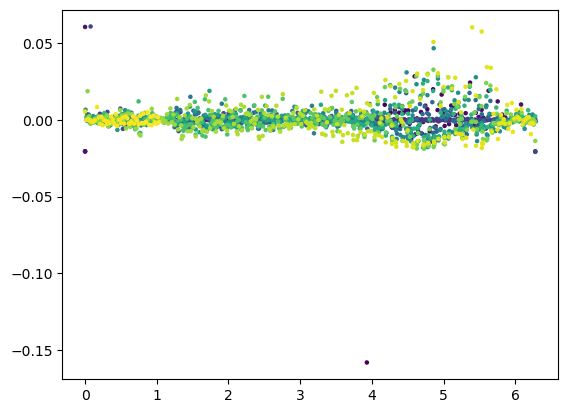

In [11]:
plt.scatter(range(oog.delta_phases.shape[0]), np.cumsum(oog.delta_phases - (2 * np.pi / oog.sequence_manager.reference_period)), s = 5, c = oog.phases[1::])
plt.show()

plt.scatter(oog.phases[1::], np.cumsum(oog.delta_phases - (2 * np.pi / oog.sequence_manager.reference_period)), s = 5, c = range(oog.delta_phases.shape[0]))
plt.show()

plt.scatter(oog.phases[1::], oog.delta_phases - (2 * np.pi / oog.sequence_manager.reference_period), s = 5, c = range(oog.delta_phases.shape[0]))
plt.show()

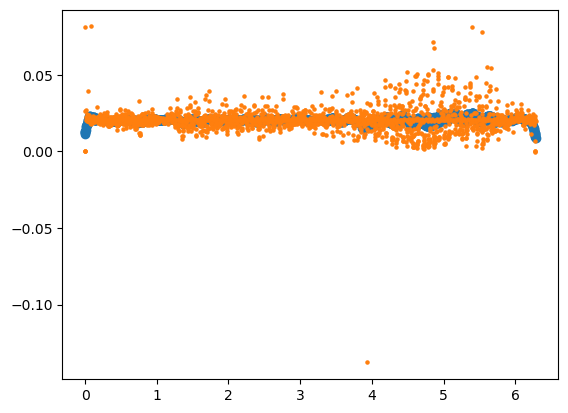

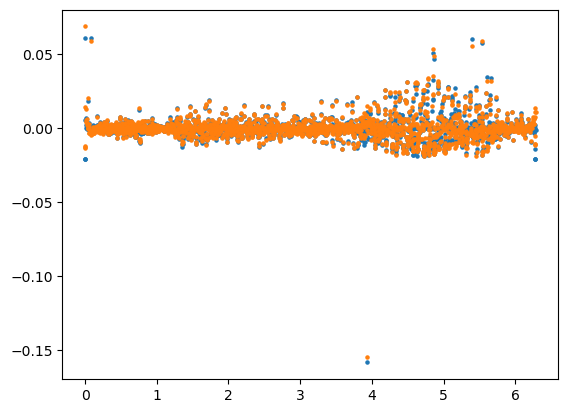

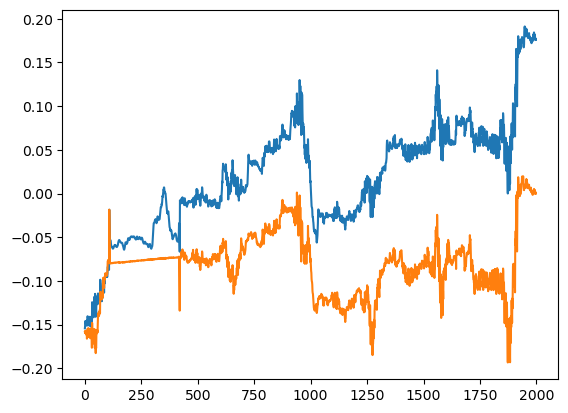

In [12]:
order = np.argsort(oog.phases[1::])
# Get moving average of the phase-delta phase plot
window = 38
weights = np.repeat(1.0, window)/window
ma = np.convolve(oog.delta_phases[order], weights, 'same')

plt.scatter(oog.phases[1::], ma[np.argsort(order)])
plt.scatter(oog.phases[1::], oog.delta_phases, s = 5)
plt.show()
# Subtract moving average from delta phase
delta_phases = oog.delta_phases - ma[np.argsort(order)]
# and plot
plt.scatter(oog.phases[1::], oog.delta_phases - np.mean(oog.delta_phases), s = 5)
plt.scatter(oog.phases[1::], delta_phases, s = 5)
plt.show()

plt.plot(np.cumsum(delta_phases))
plt.plot(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)))
plt.show()

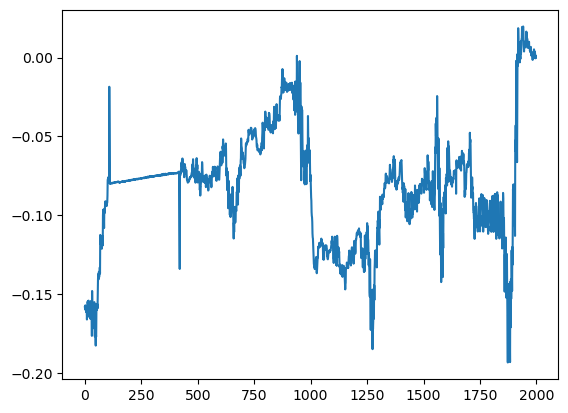

In [13]:
plt.plot(range(oog.delta_phases.shape[0]), np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)))
plt.show()

0.020494303845033188


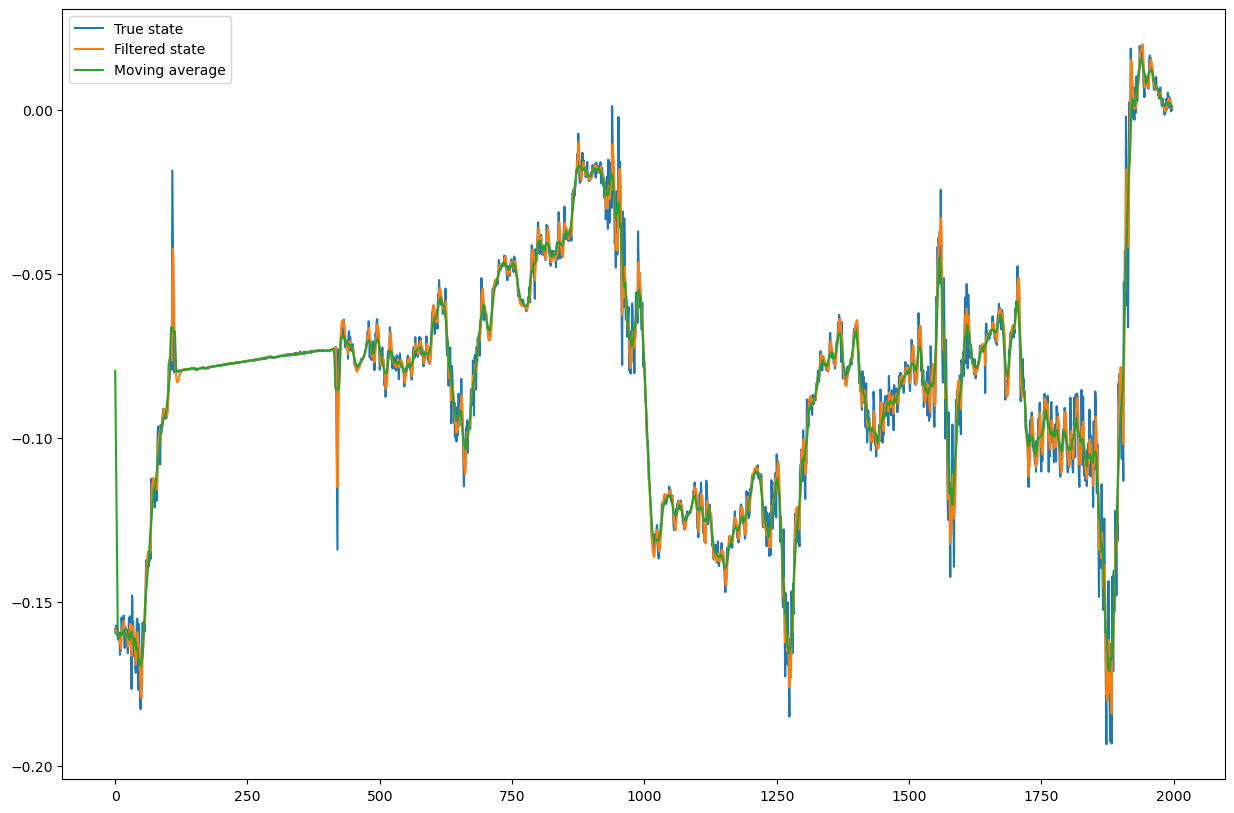

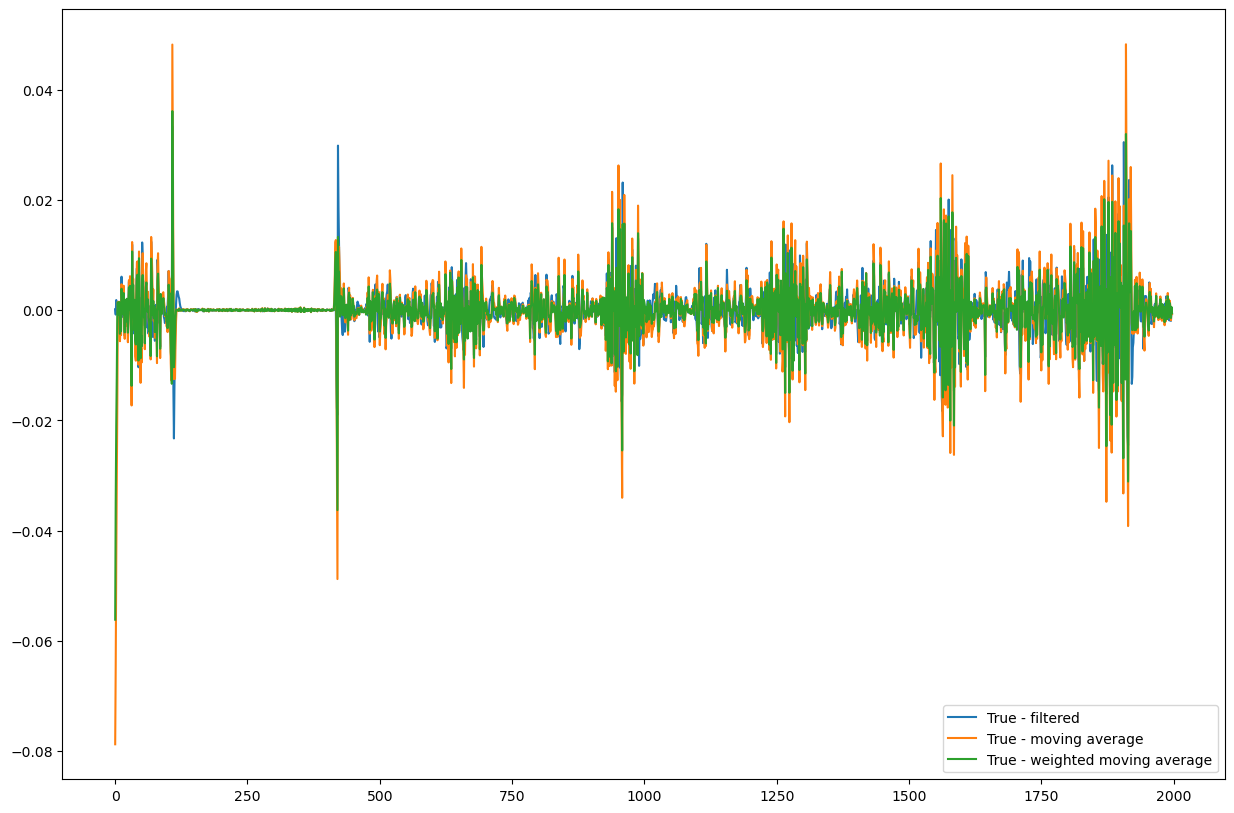

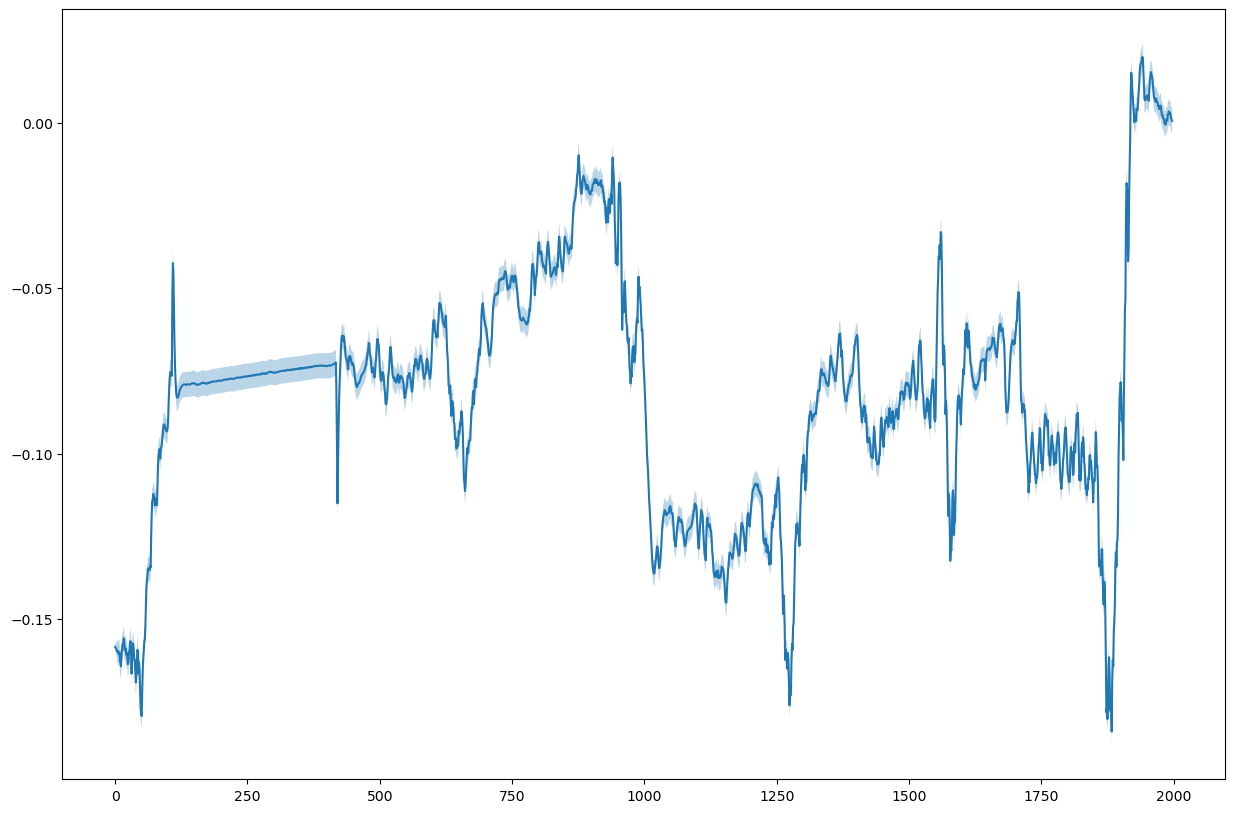

In [14]:
from pykalman import KalmanFilter as pyKalmanFilter
dt = 1
x_0 = [0, 0]
q = 0.001
window = 10
Q = np.array([[dt**3 / 3, dt**2 / 2], 
                    [dt**2 / 2, dt]]) * q**2
kf = pyKalmanFilter(initial_state_mean = x_0, observation_matrices=[[1, 0]], transition_matrices = [[1, dt], [0, 1]], observation_covariance = [[0.1]], transition_covariance=Q, em_vars = ['initial_state_mean', 'transition_covariance', 'observation_covariance', 'initial_state_covariance'])
kf.em(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)), n_iter = 10)
(filtered_state_means, filtered_state_covariances) = kf.filter(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)))
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)))
plt.figure(figsize = (15, 10))
print(np.mean(oog.delta_phases))
plt.plot(range(oog.delta_phases.shape[0]), np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)), label = 'True state')
plt.plot(range(oog.delta_phases.shape[0]), filtered_state_means[:,0], label = 'Filtered state')
# Plot moving average
weights = np.repeat(1.0, window)/window
ma = np.convolve(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)), weights, 'same')
plt.plot(range(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)).shape[0]), ma, label = 'Moving average')
# Plot weighted moving average with weights 1/8, 1/4, 1/4, 1/4, 1/8
weights = np.array([1, 1, 1, 2, 4, 2, 1, 1, 1])
weights = weights / np.sum(weights)
ma2 = np.convolve(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)), weights, 'same') 
#plt.plot(range(np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)).shape[0]), ma2, label = 'Weighted moving average')
plt.legend()
plt.show()

# Plot differences between true and filtered states and moving averages
plt.figure(figsize = (15, 10))
plt.plot(range(oog.delta_phases.shape[0]), np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)) - filtered_state_means[:,0], label = 'True - filtered')
plt.plot(range(oog.delta_phases.shape[0]), np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)) - ma, label = 'True - moving average')
plt.plot(range(oog.delta_phases.shape[0]), np.cumsum(oog.delta_phases - np.mean(oog.delta_phases)) - ma2, label = 'True - weighted moving average')
plt.legend()
plt.show()

# Plot pykalman uncertainties
plt.figure(figsize = (15, 10))
plt.plot(range(oog.delta_phases.shape[0]), filtered_state_means[:,0])
plt.fill_between(range(oog.delta_phases.shape[0]), filtered_state_means[:,0] - np.sqrt(filtered_state_covariances[:,0,0]), filtered_state_means[:,0] + np.sqrt(filtered_state_covariances[:,0,0]), alpha = 0.3)
plt.show()

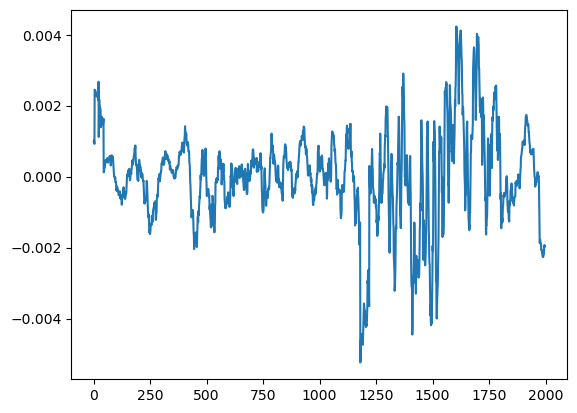

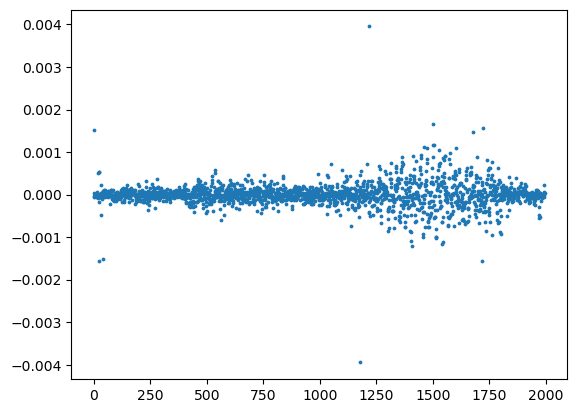

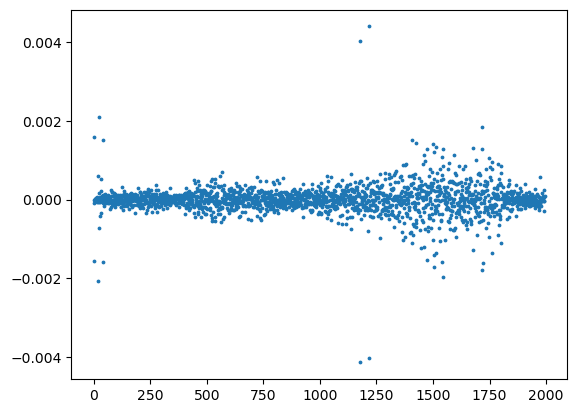

In [15]:
# Get differences of moving average
order = np.argsort(oog.phases[1::])
window = 40
weights = np.repeat(1.0, window)/window
ma = np.convolve(np.cumsum(oog.delta_phases[order] - np.mean(oog.delta_phases)), weights, 'same')
ma_diff = np.diff(ma)
plt.plot(range(ma_diff.shape[0]), ma_diff)
plt.show()
# Get differences of differences of moving average
ma_diff_diff = np.diff(ma_diff)
plt.scatter(range(ma_diff_diff.shape[0]), ma_diff_diff, s = 3)
plt.show()
# Get the differences of the differences of the differences of the moving average
ma_diff_diff_diff = np.diff(ma_diff_diff)
plt.scatter(range(ma_diff_diff_diff.shape[0]), ma_diff_diff_diff, s = 3)
plt.show()

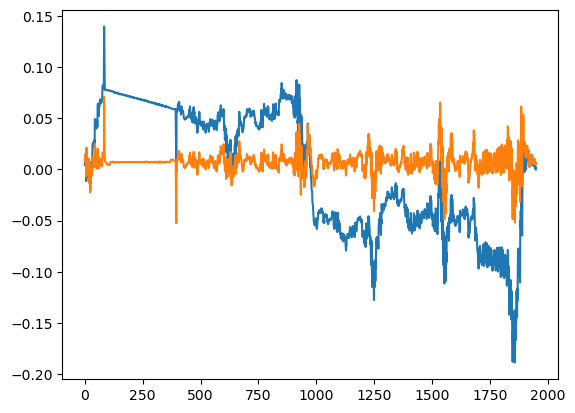

In [16]:
# Plot delta phases with moving average subtracted
weights = 50
ma = np.convolve(oog.delta_phases, np.repeat(1.0, weights)/weights, 'valid')
# Now plot the cumulative sum of the delta phases with moving average subtracted
plt.plot(np.cumsum(oog.delta_phases[weights //2:-weights//2 + 1] - np.mean(oog.delta_phases[weights //2:-weights//2 + 1])))
plt.plot(np.cumsum(oog.delta_phases[weights // 2:-weights//2 + 1] - ma))
plt.show()

ADF Statistic: -8.671791
p-value: 0.000000


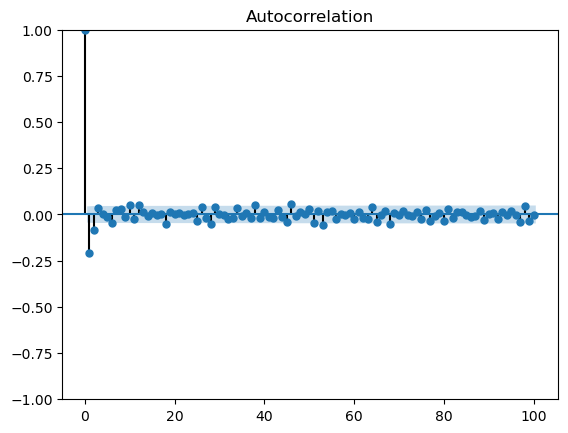

c:\Users\kross\anaconda3\envs\optical-gating\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 259.345
Date:                Thu, 21 Mar 2024   AIC                           -510.689
Time:                        13:24:24   BIC                           -500.309
Sample:                             0   HQIC                          -506.489
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8529      0.871     -0.979      0.328      -2.560       0.855
ma.L1         -0.0376      0.894     -0.042      0.966      -1.791       1.715
ma.L2         -0.7308      0.787     -0.928      0.3

c:\Users\kross\anaconda3\envs\optical-gating\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


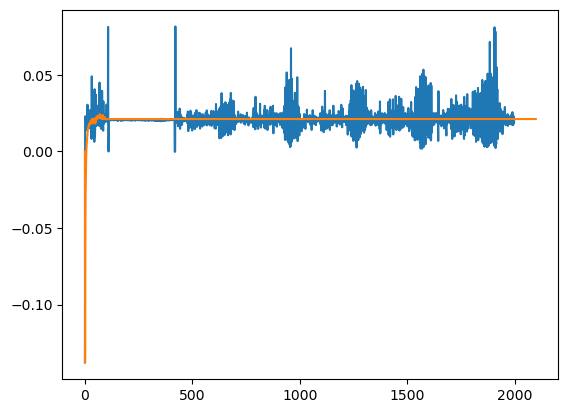

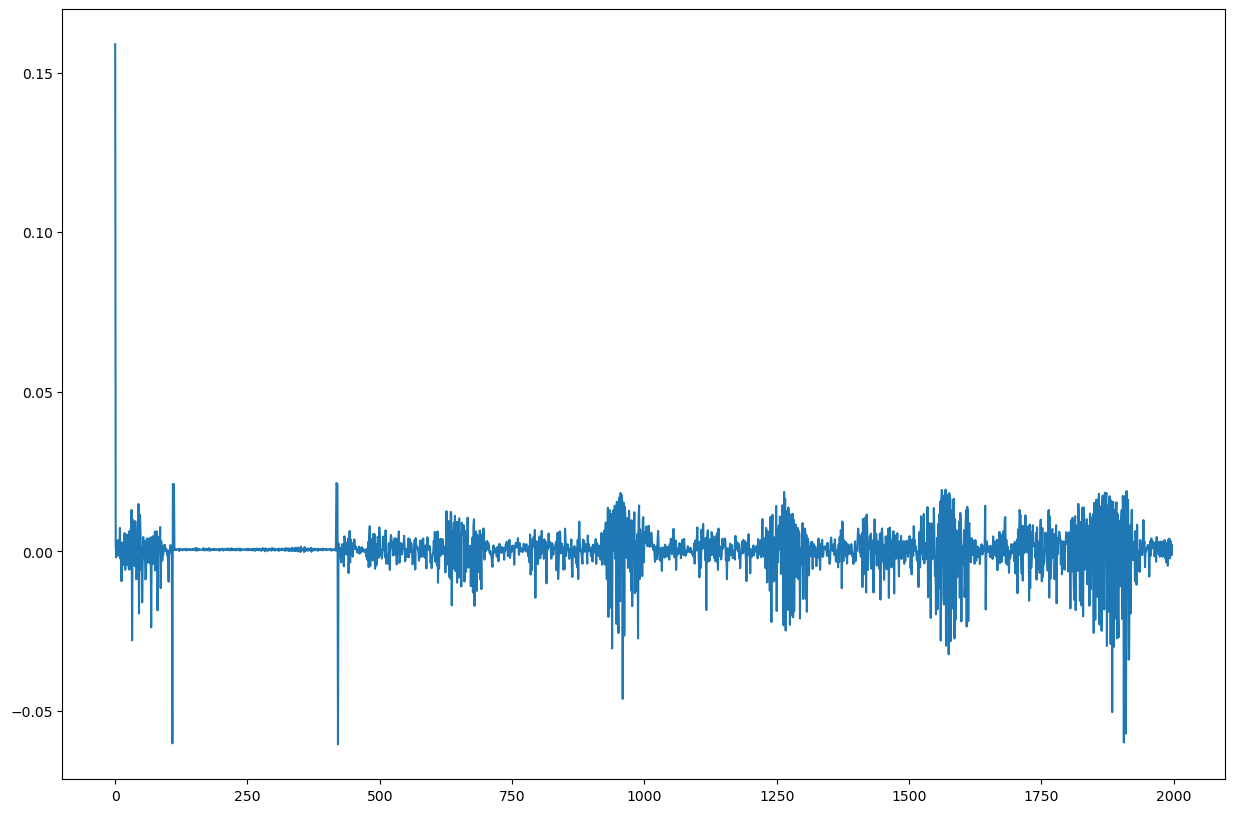

In [17]:
# Run ARIMA forecasting
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Run ARIMA on delta phases
# Check for stationarity
result = adfuller(oog.delta_phases[0:100])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Plot ACF and PACF
plot_acf(oog.delta_phases, lags = 100)
plt.show()

# Now make forward predictions
model = ARIMA(oog.delta_phases[0:100], order = (1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())
# Make predictions
predictions = model_fit.predict(start = 0, end = oog.delta_phases.shape[0] + 100)
plt.plot(oog.delta_phases)
plt.plot(predictions)
plt.show()

# Plot difference between predictions and true values
plt.figure(figsize = (15, 10))
plt.plot(predictions[101::] - oog.delta_phases)
plt.show()
